<a href="https://colab.research.google.com/github/MaLuisa7/Machine_Learning_Lessons/blob/main/stock_price_prediction_ML_20230312.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción del movimiento de la acción de bolsa "S & P 500"**

## 1. Carga de librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import sklearn
from sklearn.metrics import precision_score

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib


import warnings
warnings.filterwarnings('ignore')
! pip install yfinance
import yfinance as yf
from datetime import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. Carga de Datos

Interesa conocer como se ha comportado la acción en los últimos 23 años.

In [ ]:
ticker = yf.Ticker('SPY')
end_date = '2023-01-23'
start_date = '2000-01-23'
sp500 = ticker.history(start=start_date,end=end_date)
sp500.drop(columns = ['Stock Splits',	'Capital Gains','Dividends'], inplace = True)
print("Shape of SP 500 data is:", sp500.shape)
sp500.head(2)

Shape of SP 500 data is: (5786, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-24 00:00:00-05:00,95.45217,95.575044,91.356389,91.970757,7896900
2000-01-25 00:00:00-05:00,92.08340,93.015190,91.090173,93.015190,9942500


In [ ]:
sp500['day'] = sp500.index.day
sp500['month'] = sp500.index.month
sp500['year'] = sp500.index.year
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500['is_quarter_end'] = np.where(sp500['month']%3==0,1,0)
sp500['open-close']  = sp500['Open'] - sp500['Close']
sp500['low-high']  = sp500['Low'] - sp500['High']
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
sp500.head(3)

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24 00:00:00-05:00,95.452170,95.575044,91.356389,91.970757,7896900,24,1,2000,93.015190,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-25 00:00:00-05:00,92.083400,93.015190,91.090173,93.015190,9942500,25,1,2000,92.277924,0,...,1.005646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-26 00:00:00-05:00,92.400797,92.759178,91.806909,92.277924,5158100,26,1,2000,91.909317,0,...,0.996021,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Análisis Descriptivo

Comportamiento del cierre del precio

Text(0.5, 0, 'Años')

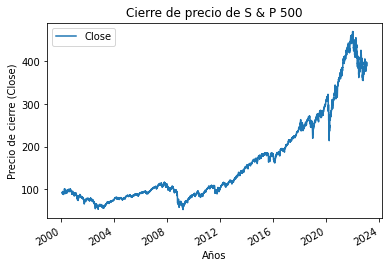

In [ ]:
sp500.plot.line(y="Close", use_index=True)
plt.title("Cierre de precio de S & P 500")
plt.ylabel("Precio de cierre (Close)")
plt.xlabel("Años")

Histogramas de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

In [ ]:
sp500.shape

(5786, 23)

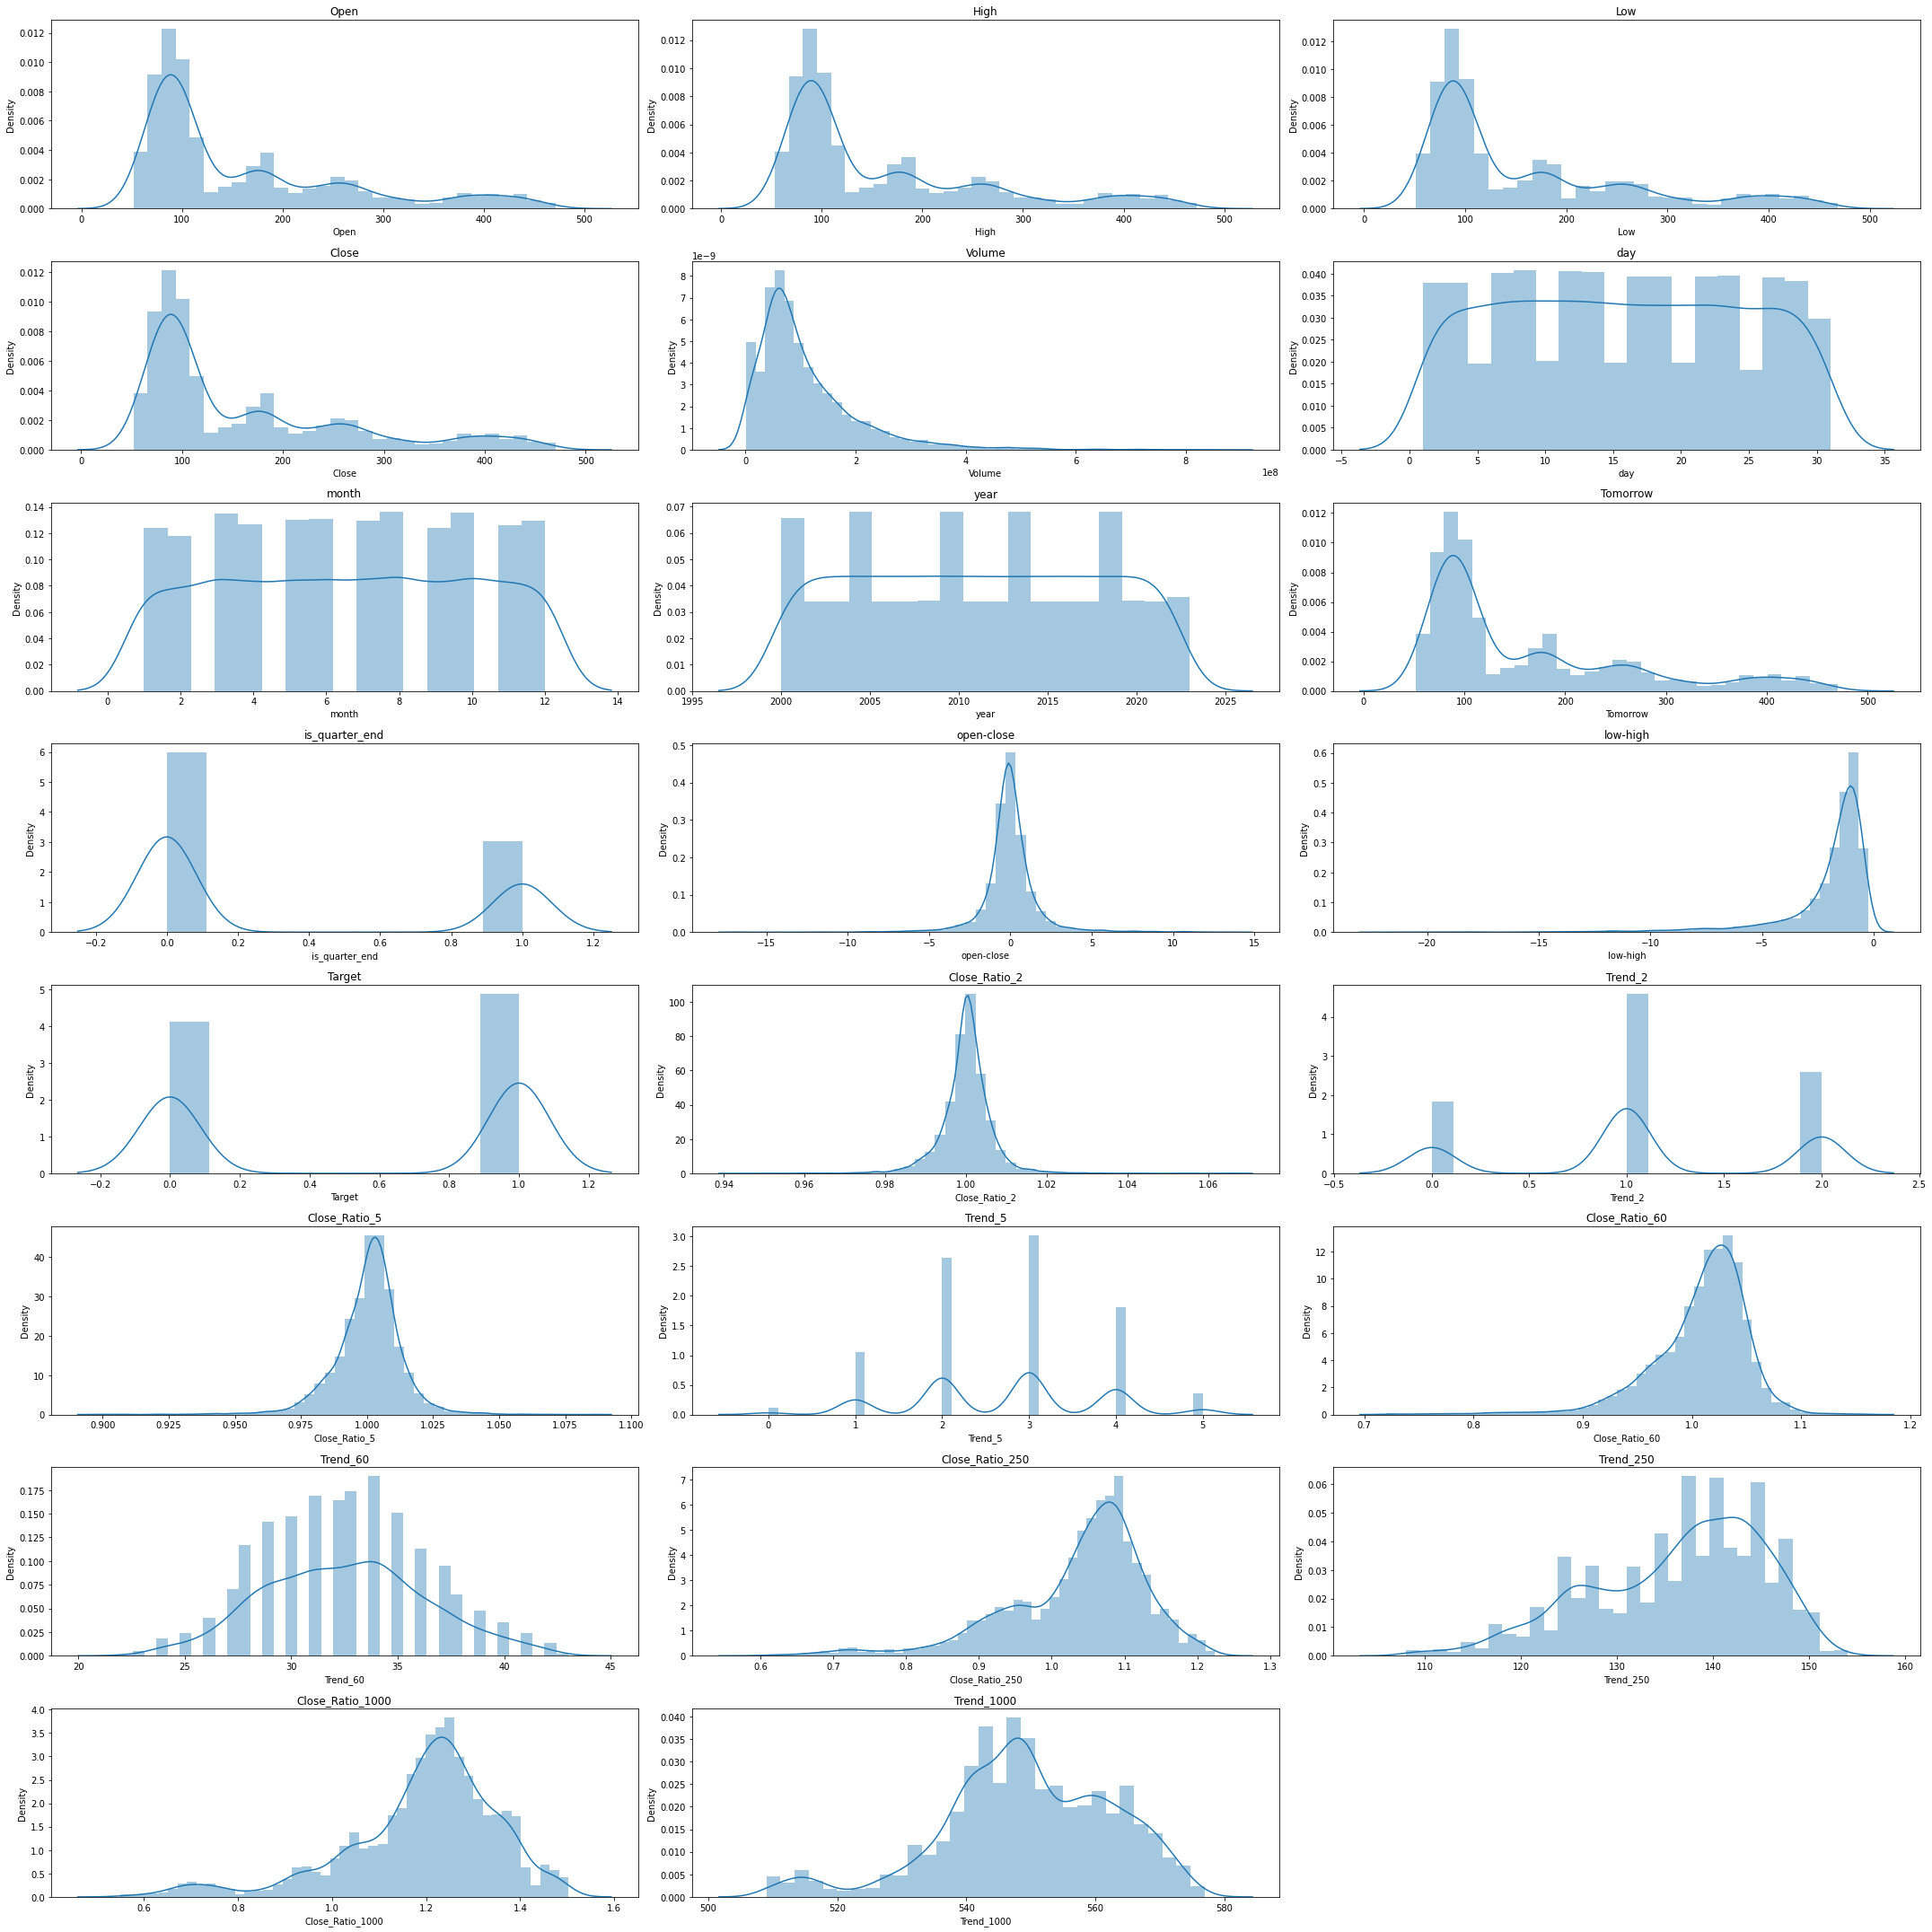

In [ ]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.distplot(sp500[col]).set(title=sp500[col].name)
plt.show()

* Se observa que las distribuciones tanto para Open, High , Low y Close de la acción S&P 500 se comportan similarmente. 

* Para la variable volumen tiene una distribución muy parecida a la de una Chi cuadrada.

Diagrama de cajas y bigote de las variables de apertura (Open) y  cierre (Close) del precio asi como su valor más alto (High) y bajo (Low). 

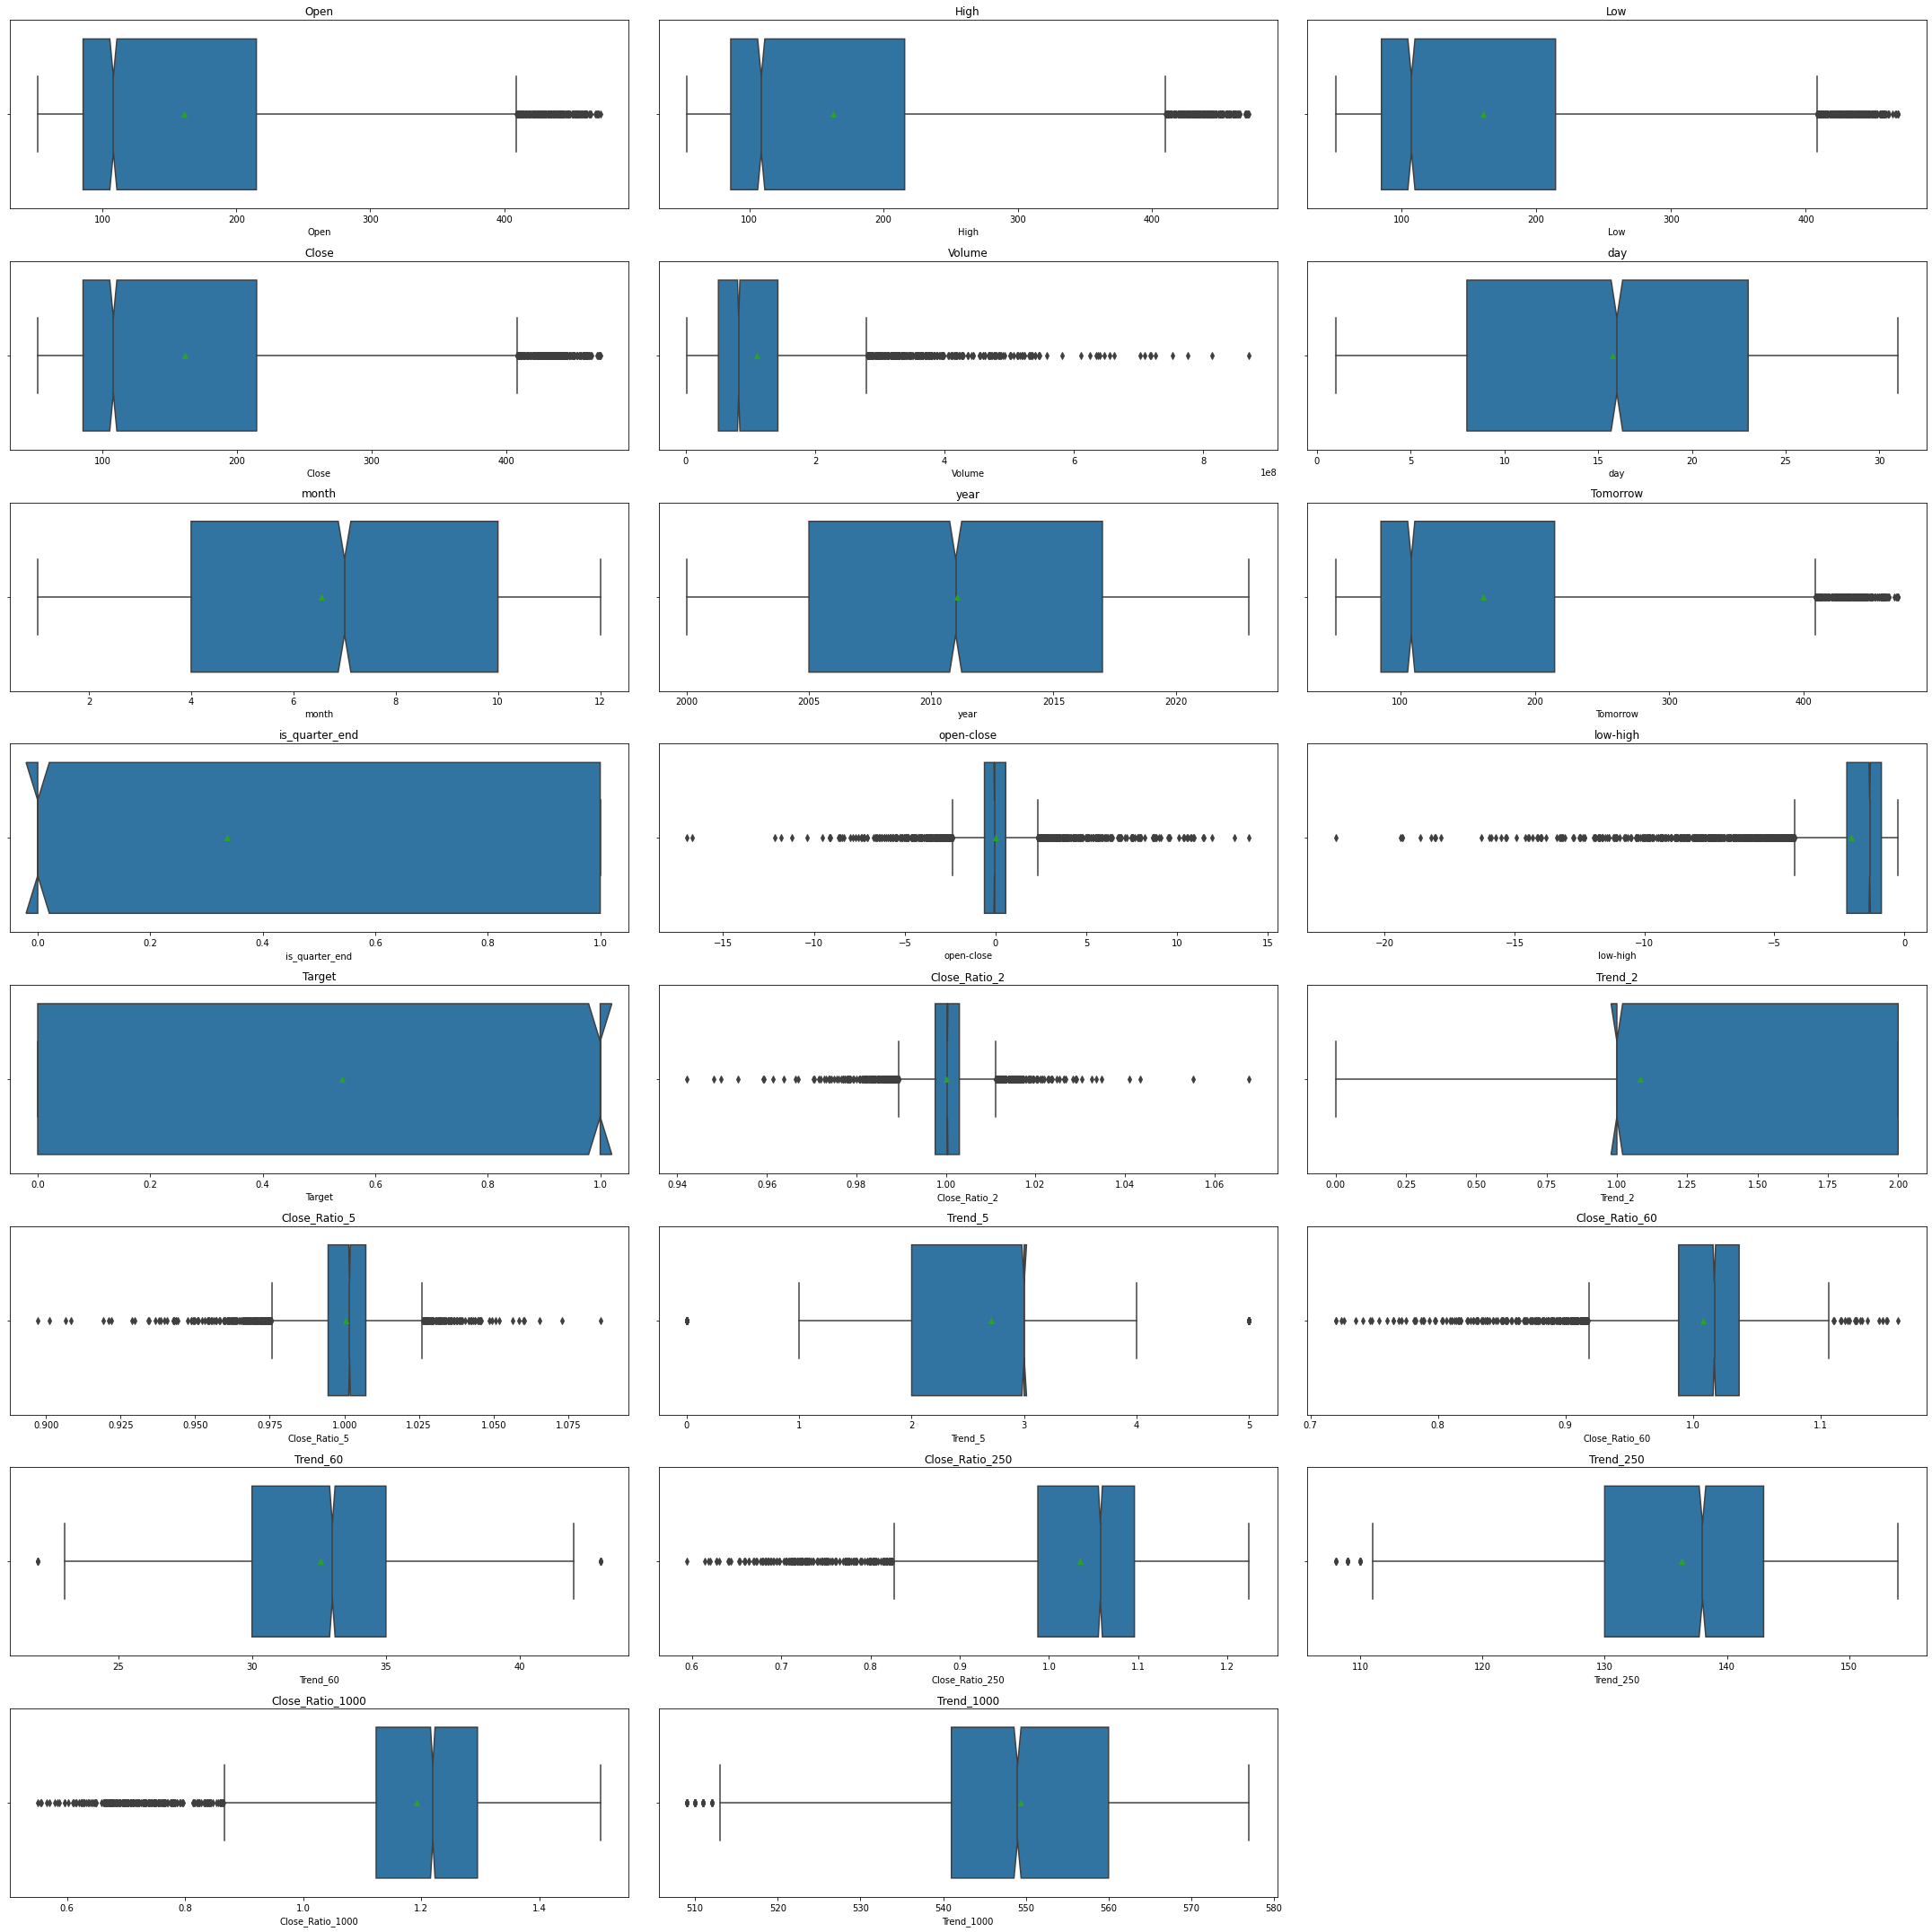

In [ ]:
features =sp500.columns.to_list()  
plt.subplots(figsize=(30,30))
for i, col in enumerate(features):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  sns.boxplot(sp500[col], showmeans=True, notch=True).set(title=sp500[col].name)
plt.show()

Es posible concluir que las variables Open, High, Low y Close se comportan similarmente, mientras que la variable volumen se concentra en el valor 1.

In [ ]:
sp500.columns.to_list()  

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'day',
 'month',
 'year',
 'Tomorrow',
 'is_quarter_end',
 'open-close',
 'low-high',
 'Target',
 'Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

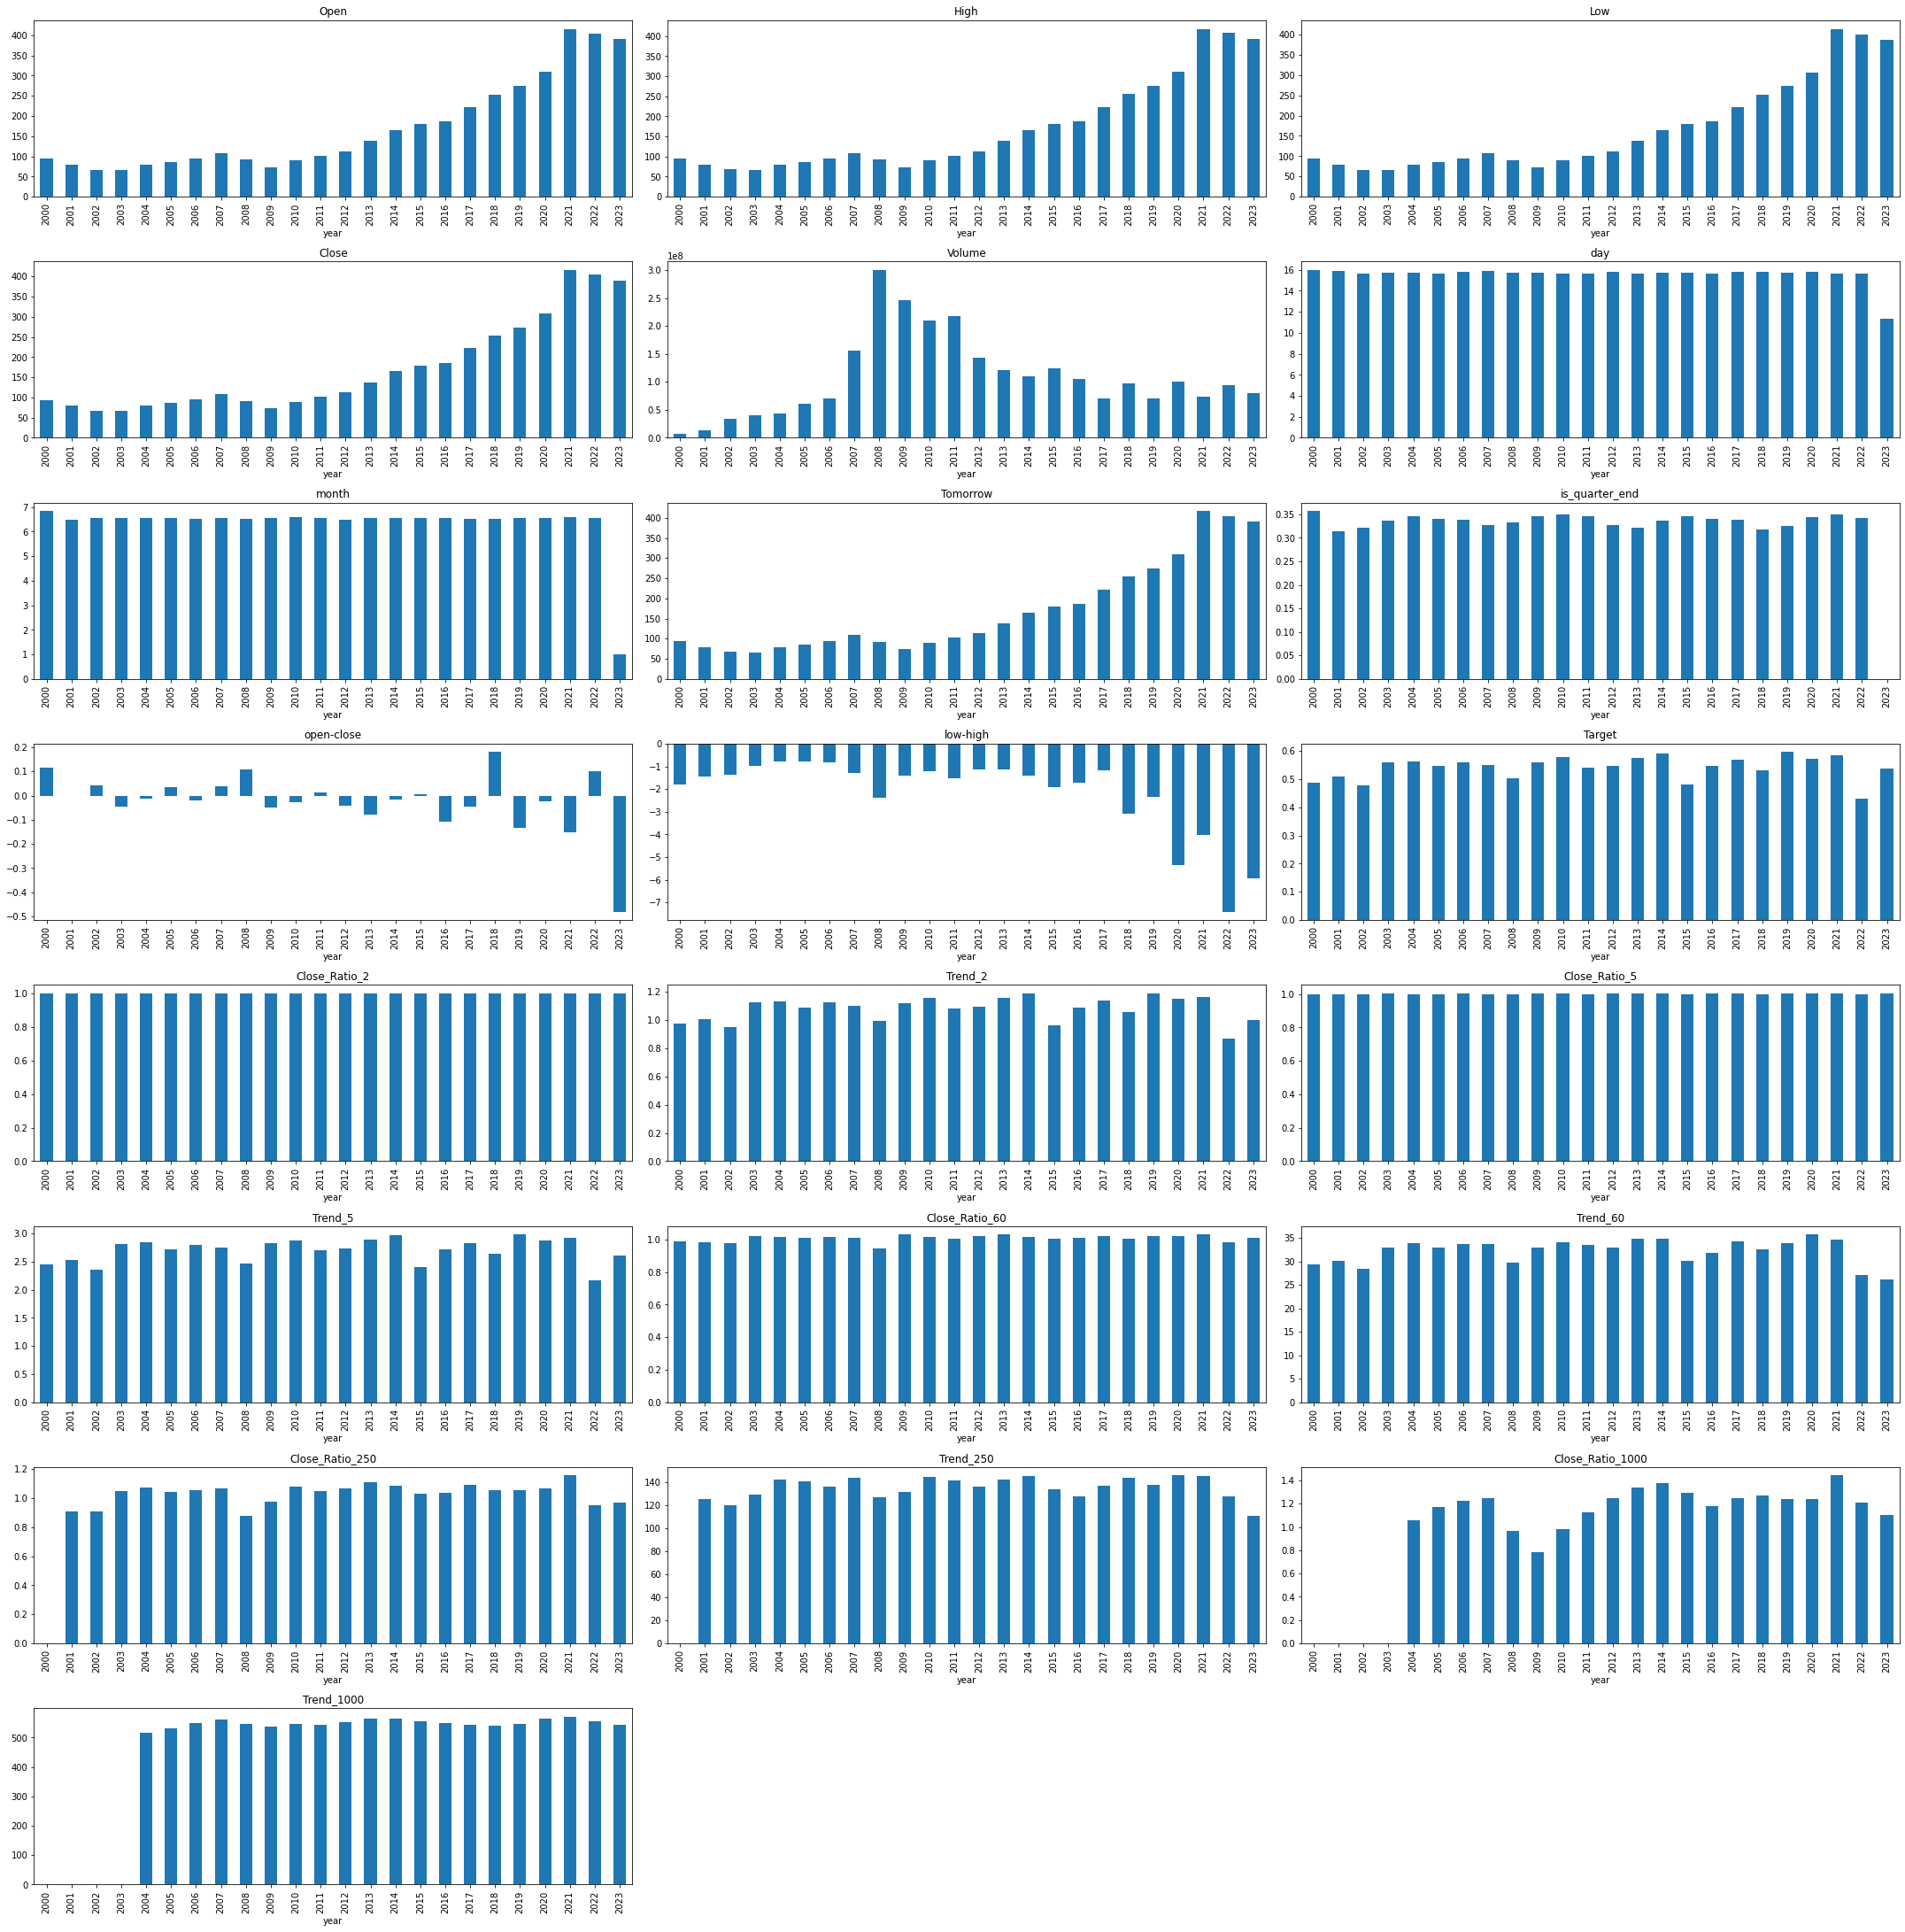

In [ ]:
features_2 = ['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month',  'Tomorrow', 'is_quarter_end',
 'open-close', 'low-high', 'Target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_60',
 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']

data_grouped = sp500.groupby('year').mean()
plt.subplots(figsize=(30,30))
for i, col in enumerate(features_2):
  plt.subplot(8,3,i+1)
  plt.tight_layout()
  data_grouped[col].plot.bar().set(title=sp500[col].name)
plt.show()

In [ ]:
sp500.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,open-close,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
is_quarter_end,,,,,,,,,,,,,,,,,,,,,
0,161.073450,162.034320,160.034916,161.113514,1.083469e+08,15.716033,6.094742,2011.063248,161.134528,-0.040063,...,1.000205,1.102604,1.000813,2.749544,1.008510,32.522208,1.035444,136.275224,1.193350,549.349417
1,161.873856,162.855281,160.758036,161.812728,1.116114e+08,15.777263,7.433642,2011.049383,161.806775,0.061128,...,0.999970,1.045267,0.999959,2.629630,1.006318,32.593961,1.034570,136.388919,1.189217,549.373994


Descriptivos de las variables

In [ ]:
sp500.describe()

,Open,High,Low,Close,Volume,day,month,year,Tomorrow,is_quarter_end,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
count,5786.000000,5786.000000,5786.000000,5786.000000,5.786000e+03,5786.000000,5786.000000,5786.000000,5785.000000,5786.000000,...,5785.000000,5784.000000,5782.000000,5781.00000,5727.000000,5726.000000,5537.000000,5536.000000,4787.000000,4786.000000
mean,161.342373,162.310150,160.277873,161.348438,1.094437e+08,15.736606,6.544590,2011.058590,161.360431,0.335983,...,1.000126,1.083333,1.000526,2.70922,1.007775,32.546280,1.035150,136.313403,1.191956,549.357710
std,104.515278,105.105020,103.854613,104.524975,9.378770e+07,8.756285,3.426295,6.634333,104.530030,0.472374,...,0.006240,0.695311,0.012706,1.07586,0.044766,3.824655,0.095903,8.895694,0.164496,13.404998
min,51.835065,53.398892,51.186656,51.957123,1.436600e+06,1.000000,1.000000,2000.000000,51.957123,0.000000,...,0.942122,0.000000,0.897272,0.00000,0.719865,22.000000,0.594101,108.000000,0.550481,509.000000
25%,85.696719,86.213547,85.156389,85.644842,5.048282e+07,8.000000,4.000000,2005.000000,85.642387,0.000000,...,0.997597,1.000000,0.994566,2.00000,0.988669,30.000000,0.987592,130.000000,1.123520,541.000000
50%,108.289408,108.929882,107.400256,108.153286,8.184750e+07,16.000000,7.000000,2011.000000,108.155052,0.000000,...,1.000328,1.000000,1.001733,3.00000,1.016641,33.000000,1.057602,138.000000,1.219436,549.000000
75%,214.991565,215.733235,214.329047,214.692986,1.423810e+08,23.000000,10.000000,2017.000000,214.726746,1.000000,...,1.002991,2.000000,1.007189,3.00000,1.036071,35.000000,1.095794,143.000000,1.295088,560.000000
max,471.569592,472.317469,468.460014,470.083649,8.710263e+08,31.000000,12.000000,2023.000000,470.083649,1.000000,...,1.067685,2.000000,1.085719,5.00000,1.160691,43.000000,1.224335,154.000000,1.502901,577.000000


Matriz de correlación

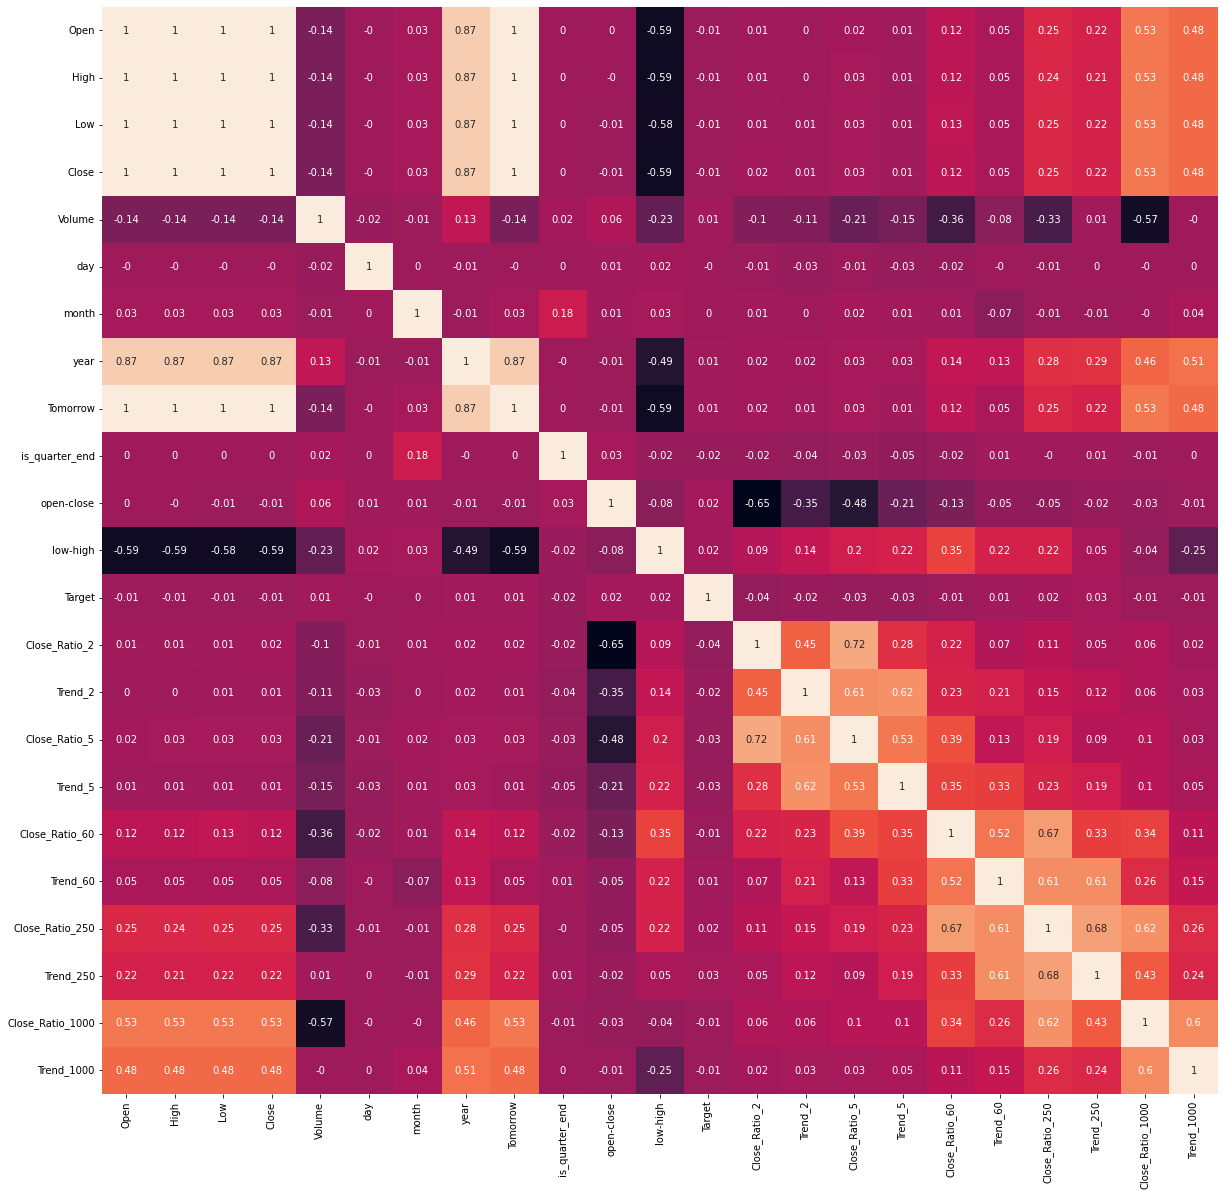

In [ ]:
plt.figure(figsize=(20, 20))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sns.heatmap(round(sp500.corr(),2) , annot=True, cbar=False)
plt.show()

Se agregan características que contribuyen a que los datos que se analizan sean más significativos

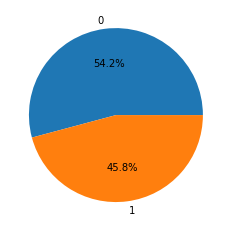

In [ ]:
plt.pie(sp500['Target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=250, min_samples_split=100, random_state=7)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

predictors =['Open', 'High', 'Low', 'Close',
 'Volume', 'day', 'month', 'year',  'is_quarter_end', 'open-close', 'low-high',
 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']
model_rf.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=250, random_state=7)

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

predictors =['Open', 'High', 'Low', 'Close',
 'Volume', 'day', 'month', 'year',  'is_quarter_end', 'open-close', 'low-high',
 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250', 'Close_Ratio_1000', 'Trend_1000']
model_xgb.fit(train[predictors], train["Target"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

SFS para RF

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1_rf = SFS(model_rf, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1_rf = sfs1_rf.fit(sp500[predictors], sp500.Target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   48.5s finished

[2023-03-14 03:44:35] Features: 1/10 -- score: 0.7044932079414838[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   45.6s finished

[2023-03-14 03:45:20] Features: 2/10 -- score: 0.7258098223615465[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   43.1s finished

[2023-03-14 03:46:03] Features: 3/10 -- score: 0.7343782654127482[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
sfs1_rf.subsets_

{1: {'feature_idx': (17,),
  'cv_scores': array([0.70449321]),
  'avg_score': 0.7044932079414838,
  'feature_names': ('Close_Ratio_250',)},
 2: {'feature_idx': (15, 17),
  'cv_scores': array([0.72580982]),
  'avg_score': 0.7258098223615465,
  'feature_names': ('Close_Ratio_60', 'Close_Ratio_250')},
 3: {'feature_idx': (13, 15, 17),
  'cv_scores': array([0.73437827]),
  'avg_score': 0.7343782654127482,
  'feature_names': ('Close_Ratio_5', 'Close_Ratio_60', 'Close_Ratio_250')},
 4: {'feature_idx': (9, 13, 15, 17),
  'cv_scores': array([0.74963427]),
  'avg_score': 0.7496342737722048,
  'feature_names': ('open-close',
   'Close_Ratio_5',
   'Close_Ratio_60',
   'Close_Ratio_250')},
 5: {'feature_idx': (9, 13, 15, 17, 19),
  'cv_scores': array([0.75256008]),
  'avg_score': 0.7525600835945664,
  'feature_names': ('open-close',
   'Close_Ratio_5',
   'Close_Ratio_60',
   'Close_Ratio_250',
   'Close_Ratio_1000')},
 6: {'feature_idx': (9, 11, 13, 15, 17, 19),
  'cv_scores': array([0.753814]),

SE observa que el subconjunto que aporta mejor informacion al modelo de random forest es el 10:

* {'feature_idx': (1, 5, 9, 11, 13, 14, 15, 17, 19, 20),
*  'cv_scores': array([0.75653083]),
*  'avg_score': 0.7565308254963428,
*  'feature_names': (
      * 'High',
      *   'day',
      *   'open-close',
      *   'Close_Ratio_2',
      *   'Close_Ratio_5',
      *   'Trend_5',
      *   'Close_Ratio_60',
      *   'Close_Ratio_250',
      *   'Close_Ratio_1000',
      *   'Trend_1000')}}

XGB para SFS

In [ ]:
sfs1_xgb = SFS(model_xgb, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1_xgb = sfs1_xgb.fit(sp500[predictors], sp500.Target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.0s finished

[2023-03-14 04:02:36] Features: 1/10 -- score: 0.7314524555903866[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s finished

[2023-03-14 04:02:41] Features: 2/10 -- score: 0.8336468129571578[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   18.4s finished

[2023-03-14 04:03:00] Features: 3/10 -- score: 0.8884012539184953[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [ ]:
sfs1_xgb.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.73145246]),
  'avg_score': 0.7314524555903866,
  'feature_names': ('Close',)},
 2: {'feature_idx': (3, 11),
  'cv_scores': array([0.83364681]),
  'avg_score': 0.8336468129571578,
  'feature_names': ('Close', 'Close_Ratio_2')},
 3: {'feature_idx': (3, 11, 13),
  'cv_scores': array([0.88840125]),
  'avg_score': 0.8884012539184953,
  'feature_names': ('Close', 'Close_Ratio_2', 'Close_Ratio_5')},
 4: {'feature_idx': (3, 11, 13, 17),
  'cv_scores': array([0.92079415]),
  'avg_score': 0.9207941483803552,
  'feature_names': ('Close',
   'Close_Ratio_2',
   'Close_Ratio_5',
   'Close_Ratio_250')},
 5: {'feature_idx': (3, 11, 13, 15, 17),
  'cv_scores': array([0.93584117]),
  'avg_score': 0.935841170323929,
  'feature_names': ('Close',
   'Close_Ratio_2',
   'Close_Ratio_5',
   'Close_Ratio_60',
   'Close_Ratio_250')},
 6: {'feature_idx': (3, 9, 11, 13, 15, 17),
  'cv_scores': array([0.94963427]),
  'avg_score': 0.9496342737722048,
  'feature_na

In [ ]:
import sklearn
from sklearn.metrics import precision_score

model_rf2 = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

subset_sel = ['High',   'day',   'open-close',   'Close_Ratio_2',  
              'Close_Ratio_5',   'Trend_5',   'Close_Ratio_60',   
              'Close_Ratio_250',   'Close_Ratio_1000',   'Trend_1000']

model_rf2.fit(train[subset_sel], train["Target"])

pred = model_rf2.predict(test[subset_sel])  
precision_score(test.Target, pred)

0.40217391304347827

In [ ]:
model_xgb2 =model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

sp500 = sp500.dropna()
train = sp500.iloc[:-100]
test = sp500.iloc[-100:].dropna()

subset_sel = ['Close',   'Volume',   'month',
   'open-close',   'Close_Ratio_2',   'Close_Ratio_5',
   'Close_Ratio_60',   'Close_Ratio_250',   'Trend_250',   'Close_Ratio_1000']

model_xgb2.fit(train[subset_sel], train["Target"])

predxgb = model_xgb2.predict(test[subset_sel])
precision_score(test.Target, predxgb)

0.39759036144578314

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[subset_sel], train["Target"])
    preds = model.predict(test[subset_sel])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model_rf2, predictors)

In [ ]:
predictions["Predictions"].value_counts()


0    1255
1    1030
Name: Predictions, dtype: int64

In [ ]:
from sklearn.metrics import precision_score
precision_score(predictions["Target"], predictions["Predictions"])


0.5233009708737864

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.544858
0    0.455142
Name: Target, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2013-12-20 00:00:00-05:00,1,0
2013-12-23 00:00:00-05:00,1,0
2013-12-24 00:00:00-05:00,1,0
2013-12-26 00:00:00-05:00,0,0
2013-12-27 00:00:00-05:00,0,0
...,...,...
2023-01-12 00:00:00-05:00,1,1
2023-01-13 00:00:00-05:00,0,1
2023-01-17 00:00:00-05:00,0,0


In [ ]:

cf = sklearn.metrics.confusion_matrix(predictions.Target, predictions.Predictions)
cf

array([[549, 491],
       [706, 539]])

In [ ]:
(567+634)/(np.sum(cf))

0.5256017505470459

# Diseño de Experimentos (DoE)

In [ ]:
predicciones = pd.concat([pd.DataFrame(pred, columns = ['rf']), pd.DataFrame(predxgb, columns= ['xgb']), test.Target.reset_index(drop=True)],axis=1)
predicciones.head()

,rf,xgb,Target
0,1,0,0
1,1,1,0
2,1,1,0
3,1,1,1
4,1,1,0


In [ ]:
predicciones2 = pd.melt(predicciones)
predicciones2.head()

,variable,value
0,rf,1
1,rf,1
2,rf,1
3,rf,1
4,rf,1


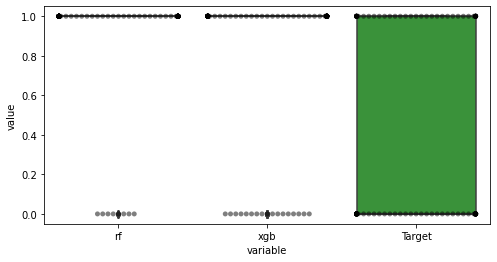

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(x="variable", y="value", data=predicciones2, ax=ax)
sns.swarmplot(x="variable", y="value", data=predicciones2, color='black', alpha = 0.5, ax=ax);

In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=6d8a76f6cd81627d0a319575a26115bbe9bfe362d91a14be01cc1d34775c55bf
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [ ]:
import pingouin as pg
pg.normality(data=predicciones2, dv='value', group='variable')


,W,pval,normal
variable,,,
rf,0.300727,1.155558e-19,False
xgb,0.453683,1.458731e-17,False
Target,0.624511,1.288219e-14,False


Los datos nos siguen una distribución normal.

In [ ]:
pg.homoscedasticity(data=predicciones2, dv='value', group='variable', method='levene')

,W,pval,equal_var
levene,18.928384,1.831299e-08,False


In [ ]:
pg.pairwise_tukey(data=predicciones2, dv='value', between='variable').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Target,rf,0.41,0.92,-0.51,0.055,-9.197,0.000,-1.273
1,Target,xgb,0.41,0.83,-0.42,0.055,-7.574,0.000,-0.951
2,rf,xgb,0.92,0.83,0.09,0.055,1.623,0.237,0.272


In [ ]:
# Test ANOVA de una vía (One-way ANOVA)
# ==============================================================================
pg.anova(data=predicciones2, dv='value', between='variable', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,variable,14.82,2,7.410000,48.19908,7.442734e-19,0.24504
1,Within,45.66,297,0.153737,NaN,NaN,NaN


### Conclusión DoE

Es importante destacar que los datos no siguen una distribución normal. Sin embargo se continuo con el Diseño de Experimentos y se concluyo que como el  p-value es muy cercano a cero y el  alfa de 0.05. 

Se conoce que se rechaza $H_0$ si pvalor es menor a $\alpha$.

Entonces, se rechaza $H_0$ ,  los grupos que se compararon no tienen la misma media.

[Literatura citada](https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html)



## Citas

* https://www.youtube.com/watch?v=1O_BenficgE
* https://github.com/dataquestio/project-walkthroughs/blob/master/sp_500/market_prediction.ipynb
* http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#sequential-forward-selection-sfs
* https://iopscience.iop.org/article/10.1088/1742-6596/2161/1/012065/pdf
* file:///C:/Users/Maria%20Luisa/Downloads/Successful%20Algorithmic%20Trading.pdf